In [306]:
import sys # in order to import QLearning* modules
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
import logging
from QLearningBoltzmann import QLearningBoltzmann as boltz
from QLearningEGreedy import QLearningEGreedy as egreedy
from QLearningUCB import QLearningUCB as ucb
import pandas as pd
import seaborn as sns
import scipy.stats as st
from pathlib import Path

from threading import Thread
from threading import RLock as lock
import time

In [307]:
home = str(Path.home())

f_csma_list = [
    home + "/Temp/SOMAC-ML/data/_BKP/29092018/csma/round2/backlog_file.npy", # RUN
    home + "/Temp/SOMAC-ML/data/10102018/round1/csma/backlog_file.npy",      # RUN3
    home + "/Temp/SOMAC-ML/data/06102018/run4/5/csma/backlog_file.npy",      # RUN4
    home + "/Temp/SOMAC-ML/data/16102018/csma/csma/backlog_file.npy",        # RUN2 (CSMA)
    home + "/Temp/SOMAC-ML/data/16102018/tdma/csma/backlog_file.npy"        # RUN2 (TDMA)
    #home + "/UFMG/SOMAC-ML/data/04102018/run4/round2/csma/backlog_file.npy"  # RUN4 estranho
]

f_tdma_list = [
    home + "/Temp/SOMAC-ML/data/_BKP/29092018/tdma/round2/backlog_file.npy", # RUN
    home + "/Temp/SOMAC-ML/data/10102018/round1/tdma/backlog_file.npy",      # RUN3
    home + "/Temp/SOMAC-ML/data/06102018/run4/5/tdma/backlog_file.npy",      # RUN4
    home + "/Temp/SOMAC-ML/data/16102018/csma/tdma/backlog_file.npy",        # RUN2 (CSMA)
    home + "/Temp/SOMAC-ML/data/16102018/tdma/tdma/backlog_file.npy"        # RUN2 (TDMA)
    #home + "/UFMG/SOMAC-ML/data/04102018/run4/round2/tdma/backlog_file.npy"  # RUN4 estranho
]

In [308]:
class Simulator:
    
    def __init__(self, f_csma = "", f_tdma = "", somac = {}, init_prot = 0, alpha = 0.75, noise = 0):
        
        self.dic_csma = np.load(f_csma, encoding = "latin1").item()
        self.dic_tdma = np.load(f_tdma, encoding = "latin1").item()
        
        n = np.min([len(self.dic_csma), len(self.dic_tdma)])
        self.arr_csma = np.array([self.dic_csma[t]["metrics"][0, 1] for t in range(n)]) + noise
        self.arr_tdma = np.array([self.dic_tdma[t]["metrics"][0, 1] for t in range(n)]) + noise
        
        self.somac = somac
        
        self.init_prot = init_prot
        self.alpha = alpha
        
        logging.basicConfig(filename = "/tmp/out.log", level = logging.INFO)
        
        return
    
    def calc_reward(self, backlog, t, dt):
        if dt == 2:
            reward = self._reward(backlog["metric"][t], backlog["metric"][t-2])
        elif dt == 3:
            reward = self._reward(backlog["metric"][t], backlog["metric"][t-3])
        else:
            reward = self._reward(backlog["metric"][t], backlog["metric"][t-1])

            if reward >= 0:
                reward = 0.
            else:
                reward = reward

        return reward
    
    def _reward(self, curr, prev):
        if curr > prev:
            reward = curr / prev - 1. if prev > 0. else 0.
        else:
            reward = - (prev / curr - 1.) if curr > 0. else 0.
        if reward > 1. or reward < -1:
            reward = 1 if reward > 1 else -1

        return reward * 5.
    
    def run(self):
        
        n = len(self.arr_csma)

        prot = self.init_prot
        decision = prot
        backlog = {"metric": {}, "prot": {}}
        _backlog = {"metric": {}, "prot": {}}
        dt = -1
        
        for t in range(n):
            backlog["metric"][t] = self.arr_csma[t] if prot == 0 else self.arr_tdma[t]
            backlog["prot"][t] = prot
            
            _backlog["metric"][t] = self.arr_csma[t] if prot == 0 else self.arr_tdma[t]
            _backlog["prot"][t] = prot
            
            if dt == 1:
                backlog["metric"][t] = (backlog["metric"][t] + backlog["metric"][t-1]) / 2.
                _backlog["metric"][t] = (_backlog["metric"][t] + _backlog["metric"][t-1]) / 2.
            
            if t > 0:
                _backlog["metric"][t] = (
                    (1. - self.alpha) * _backlog["metric"][t - 1] + self.alpha * _backlog["metric"][t]
                )
                
            logging.info("Metric = {}, Protocol = {}".format(backlog["metric"][t], backlog["prot"][t]))
            
            if dt > 1:
                reward = self.calc_reward(_backlog, t, dt)
                
                self.somac.update_qtable(reward, dt)
                
                if dt == 2 and reward >= 0:
                    decision = self.somac.decision(prot, keep = True)
                elif dt == 2 and reward < 0:
                    decision = self.somac.decision(prot, force_switch = True)
                else:
                    decision = self.somac.decision(prot)
                    
                if decision != prot:
                    dt = 0
                    
                    logging.info("Protocol switch: {} => {}".format(prot, decision))
                    
            dt = dt + 1
            prot = decision
            
        self.backlog = backlog
        
        return
    
    def get_results(self):
        
        n = len(self.backlog["metric"])
        performance = np.array([self.backlog["metric"][t] for t in range(n)])
        
        n = len(self.backlog["prot"])
        protocol = np.array([self.backlog["prot"][t] for t in range(n)])
        
        return performance, protocol
    
    def get_network_scenario(self):
        
        return self.arr_csma, self.arr_tdma

In [309]:
class Stats:
    
    def __init__(self, results, csma, tdma):
        
        self.csma = csma
        self.tdma = tdma
        self.results = results
        
        self._to_df()
        
        return
        
    def _to_df(self):
        
        n_rounds = len(self.results)
        n_steps = len(self.results[0]["performance"])
        
        self.n_steps = n_steps
        self.n_rounds = n_rounds
        
        tmp = {"x": [], "y": []}
        for i in range(n_rounds):
            tmp["x"].extend(list(np.arange(n_steps)))
            tmp["y"].extend(list(self.results[i]["performance"]))
            
        self.df = pd.DataFrame.from_dict(tmp)
        
        return
    
    def calc_regret(self):
        
        arr_regret = np.zeros((self.n_rounds, self.n_steps))
        
        for r in range(self.n_rounds):
            for c in range(self.n_steps):
                opt = self.csma[c] if self.csma[c] >= self.tdma[c] else self.tdma[c]
                
                regret = (opt - self.results[r]["performance"][c]) / opt if opt > 0 else 0
                
                arr_regret[r, c] = regret if regret >= 0 else 0
                
        arr_regret = np.mean(arr_regret, axis = 0)
        
        arr_regret = np.zeros((self.n_rounds * self.n_steps, ))
        i = 0
        for r in range(self.n_rounds):
            for t in range(self.n_steps):
                opt = self.csma[t] if self.csma[t] >= self.tdma[t] else self.tdma[t]
                
                regret = (opt - self.results[r]["performance"][t]) / opt if opt > 0 else 0
                
                arr_regret[i] = regret
                i = i + 1
                
        return arr_regret
    
    def calc_cdf(self, arr):
        
        n = arr.shape[0]
        
        prob = np.arange(n) * 1. / n
        
        arr_ordered = np.sort(arr)
        
        tmp_prob = [0.]
        tmp_cdf = [0.]
        for i in range(1, n, 1):
            if arr_ordered[i-1] != arr_ordered[i]:
                tmp_prob.append(prob[i])
                tmp_cdf.append(arr_ordered[i])

        for j in range(int(arr_ordered[i] * 10), 10, 1):
            tmp_prob.append(1)
            tmp_cdf.append(i/10.)
                
        cdf = np.array(tmp_cdf)
        prob = np.array(tmp_prob)
        
        return cdf, prob
    
    def avg_ci(self, ci = 95):
        
        n_rounds = len(self.results)
        n_steps = len(self.results[0]["performance"])
        
        arr = np.zeros((n_rounds, ))
        
        for i in range(n_rounds):
            arr[i] = np.mean(self.results[i]["performance"])
        
        avg, ci = np.mean(arr), list(st.t.interval(ci/100., len(arr)-1, loc=np.mean(arr), scale=st.sem(arr)))
        
        ci[0], ci[1] = round(ci[0], 2), round(ci[1], 2)
        avg = round(avg, 2)
        avg_csma = round(np.mean(self.csma), 2)
        avg_tdma = round(np.mean(self.tdma), 2)
        
        return avg_csma, avg_tdma, avg, ci
    
    def plot(self, fig = 0, ci = 95, fig_name = ""):
        
        avg_csma, avg_tdma, avg_somac, ci_somac = self.avg_ci(ci = ci)
        
        plt.figure(fig)
        
        plt.plot(self.csma); plt.plot(self.tdma)
        
        ax = sns.lineplot(x = "x", y = "y", data = self.df, ci = ci)
        
        # Markers
        m_size = 5
        ax.lines[0].set_marker("x"); ax.lines[0].set_markersize(m_size)
        ax.lines[1].set_marker("s"); ax.lines[1].set_markersize(m_size)
        ax.lines[2].set_marker("o"); ax.lines[2].set_markersize(m_size)
        
        plt.title("CSMA = {}, TDMA = {}, SOMAC = {}, CI = {}".format(
            avg_csma, avg_tdma, avg_somac, ci_somac
        ))
        plt.legend(["CSMA", "TDMA", "SOMAC"], loc = "lower right")
        plt.grid(True)
        
        plt.savefig(fig_name, bbox_inches='tight')
        plt.clf()
        
        return

### Number of repetitions

In [310]:
n_repetition = 100
alpha = 1.

np.random.seed(int(time.time()))

noise = {}
for f_csma, f_tdma in zip(f_csma_list, f_tdma_list):
    data_csma = np.load(f_csma, encoding = "latin1").item()
    data_tdma = np.load(f_tdma, encoding = "latin1").item()
    
    n = np.min([len(data_csma), len(data_tdma)])
    
    idx = f_csma + f_tdma
    noise[idx] = np.random.rand(n_repetition, n)

### Softmax / Boltzmann

In [311]:
def run_softmax():
    fig = 0

    for f_csma, f_tdma in zip(f_csma_list, f_tdma_list):

        results = {}

        for i in range(n_repetition):
            prot = np.random.choice([0, 1], p = [0.5, 0.5])
            somac = boltz(prot = prot, learn_rate = 0.7, discount = 0.8, T = 0.5)

            prot = 0 if i % 2 == 0 else 1
            sim = Simulator(f_csma = f_csma, f_tdma = f_tdma, somac = somac, init_prot = prot, alpha = alpha,
                            noise = noise[f_csma + f_tdma][i, :])

            sim.run()
            performance, protocol = sim.get_results()

            results[i] = {"performance": performance, "protocol": protocol}

        csma, tdma = sim.get_network_scenario()

        stats = Stats(results, csma, tdma)
        regret = stats.calc_regret()
        cdf, prob = stats.calc_cdf(regret)
        
        np.save("../tmp/boltz_cdf_{}.npy".format(fig), {"cdf": cdf, "prob": prob})
        
        with my_lock:
            stats.plot(fig = fig, fig_name = "../graphs/boltz_" + str(fig) + ".pdf")

        fig = fig + 1
        
    return

### E-greedy

In [312]:
def run_egreedy():
    fig = 0

    for f_csma, f_tdma in zip(f_csma_list, f_tdma_list):

        results = {}

        for i in range(n_repetition):
            prot = np.random.choice([0, 1], p = [0.5, 0.5])
            somac = egreedy(prot = prot, learn_rate = 0.8, discount = 0.7, epsilon = 0.1)

            prot = 0 if i % 2 == 0 else 1
            sim = Simulator(f_csma = f_csma, f_tdma = f_tdma, somac = somac, init_prot = prot, alpha = alpha,
                            noise = noise[f_csma + f_tdma][i, :])

            sim.run()
            performance, protocol = sim.get_results()

            results[i] = {"performance": performance, "protocol": protocol}

        csma, tdma = sim.get_network_scenario()

        stats = Stats(results, csma, tdma)
        regret = stats.calc_regret()
        cdf, prob = stats.calc_cdf(regret)
        
        np.save("../tmp/egreedy_cdf_{}.npy".format(fig), {"cdf": cdf, "prob": prob})
        
        with my_lock:
            stats.plot(fig = fig, fig_name = "../graphs/egreedy_" + str(fig) + ".pdf")

        fig = fig + 1
        
    return

### UCB

In [313]:
def run_ucb():
    fig = 0

    for f_csma, f_tdma in zip(f_csma_list, f_tdma_list):

        results = {}

        for i in range(n_repetition):
            prot = np.random.choice([0, 1], p = [0.5, 0.5])
            somac = ucb(prot = prot, learn_rate = 0.9, discount = 0.5, c = 2)

            prot = 0 if i % 2 == 0 else 1
            sim = Simulator(f_csma = f_csma, f_tdma = f_tdma, somac = somac, init_prot = prot, alpha = alpha,
                            noise = noise[f_csma + f_tdma][i, :])

            sim.run()
            performance, protocol = sim.get_results()

            results[i] = {"performance": performance, "protocol": protocol}

        csma, tdma = sim.get_network_scenario()

        stats = Stats(results, csma, tdma)
        regret = stats.calc_regret()
        cdf, prob = stats.calc_cdf(regret)
        
        np.save("../tmp/ucb_cdf_{}.npy".format(fig), {"cdf": cdf, "prob": prob})
        
        with my_lock:
            stats.plot(fig = fig, fig_name = "../graphs/ucb_" + str(fig) + ".pdf")

        fig = fig + 1
        
    return

### Execution

In [314]:
my_lock = lock()

threads = []

try:
    threads.append(Thread(target = run_softmax, args = ()))
    threads.append(Thread(target = run_egreedy, args = ()))
    threads.append(Thread(target = run_ucb, args = ()))
    
    for thread in threads:
        thread.start()
        
    for thread in threads:
        thread.join()
    
    print("Done!")
    
except:
    print("Unable to start threads")

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Done!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### Plot CDFs

../tmp/boltz_cdf_0.npy, 
../tmp/egreedy_cdf_0.npy, 
../tmp/ucb_cdf_0.npy, 
, 0.056698418998697445, 0.12314974111165768, 0.06105744918034538


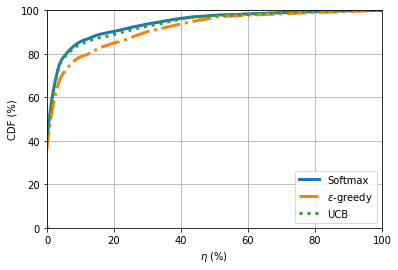

../tmp/boltz_cdf_1.npy, 
../tmp/egreedy_cdf_1.npy, 
../tmp/ucb_cdf_1.npy, 
, 0.2287811593116599, 0.2446395552573007, 0.24213573220055357


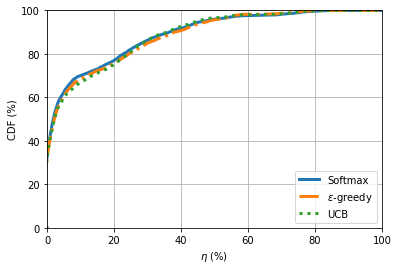

../tmp/boltz_cdf_2.npy, 
../tmp/egreedy_cdf_2.npy, 
../tmp/ucb_cdf_2.npy, 
, 0.25144316058092614, 0.2998777631027737, 0.33330248559536274


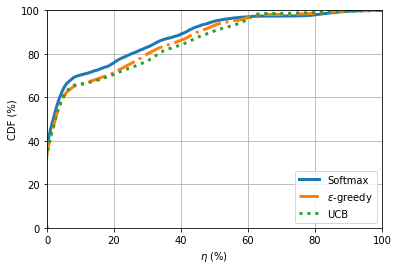

../tmp/boltz_cdf_3.npy, 
../tmp/egreedy_cdf_3.npy, 
../tmp/ucb_cdf_3.npy, 
, 0.13755076041860528, 0.22343767411001425, 0.21575706908851947


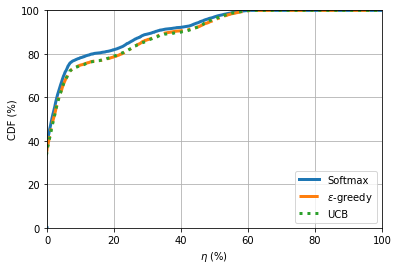

../tmp/boltz_cdf_4.npy, 
../tmp/egreedy_cdf_4.npy, 
../tmp/ucb_cdf_4.npy, 
, 0.10835896406893769, 0.11370247783165414, 0.1123792697409176


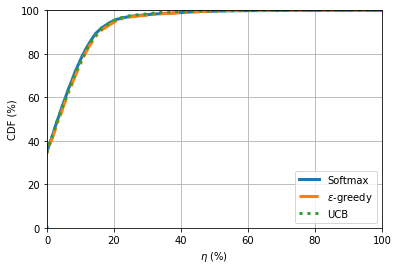

In [315]:
files = [
    "../tmp/boltz",
    "../tmp/egreedy",
    "../tmp/ucb"
]

n_scenarios = 5

for i in range(n_scenarios):
    plt.figure(i)
    
    s = ""
    
    linestyle = ["-", "-.", ":"]
    for f, ls in zip(files, linestyle):
        
        file = f + "_cdf_{}.npy".format(i)
        data = np.load(file, encoding = "latin1").item()
        plt.plot(data["cdf"] * 100, data["prob"] * 100, linestyle = ls, linewidth = 3.)
        
        print("{}, ".format(file))
        
        for j in range(data["prob"].shape[0]):
            if data["prob"][j] >= 0.8:
                s = s + ", " + str(data["cdf"][j])
                break
    
    print(s)
    
    plt.ylabel("CDF (%)"); plt.xlabel("$\eta$ (%)")
    plt.ylim([0, 100]); plt.xlim([0, 100])
    plt.legend(["Softmax", "$\epsilon$-greedy", "UCB"], loc = "lower right")
    plt.grid(True)
    
    plt.savefig("../cdf/scenario_{}.pdf".format(i))

    plt.show()